<a href="https://colab.research.google.com/github/ankitdsi2010/ECE_LBP/blob/main/QEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install pylatexenc

In [ ]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import asin, sqrt, log

In [ ]:
data = [
    (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (1, None), (0, 1), (1, 0)
]

In [ ]:
def prob_to_angle(prob):
    return 2*asin(sqrt(prob))


def log_likelihood(data, prob_a_b, prob_a_nb, prob_na_b, prob_na_nb):
    def get_prob(point):    
        if point[0] == 1 and point[1] == 1:
            return log(prob_a_b)
        elif point[0] == 1 and point[1] == 0:
            return log(prob_a_nb)
        elif point[0] == 0 and point[1] == 1:
            return log(prob_na_b)
        elif point[0] == 0 and point[1] == 0:
            return log(prob_na_nb)
        else:
            return log(prob_a_b+prob_a_nb)

    return sum(map(get_prob, data))

In [ ]:
def qbn(data, hist=True): 
    qc = QuantumCircuit(2)

    list_a = list(filter(lambda item: item[0] == 1, data))
    list_na = list(filter(lambda item: item[0] == 0, data))

    # set the marginal probability of A
    qc.ry(prob_to_angle(
        len(list_a) / len(data)
    ), 0)

    # set the conditional probability of NOT A and (B / not B)
    qc.x(0)
    qc.cry(prob_to_angle(
        sum(list(map(lambda item: item[1], list_na))) /  len(list_na)
    ),0,1)
    qc.x(0)

    # set the conditional probability of A and (B / not B)
    qc.cry(prob_to_angle(
        sum(list(map(lambda item: item[1], list_a))) /  len(list_a)
    ),0,1)

    results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
    
    return (qc, plot_histogram(results, figsize=(12,4)) if hist else results)

In [ ]:
c, p = qbn(list(filter(lambda item: item[1] is not None ,data)))

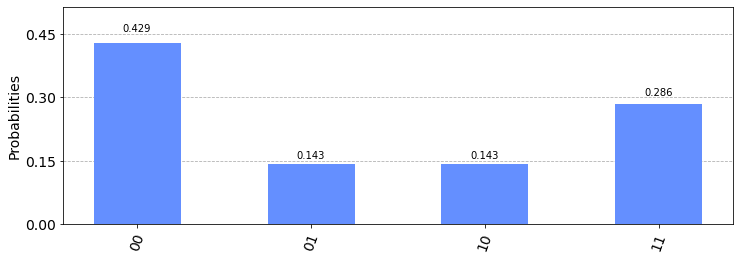

In [ ]:
p

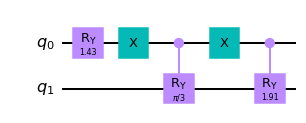

In [ ]:
c.draw(output='mpl')

In [ ]:
def eval_qbn(model, prepare_data, data):
    _, results = model(prepare_data(data), hist=False)
    return (
        round(log_likelihood(data, 
            results['11'], # prob_a_b
            results['01'], # prob_a_nb
            results['10'], # prob_na_b
            results['00']  # prob_na_nb
        ), 3),
        results['11'] / (results['11'] + results['01'])
    )

In [ ]:
p_i = 0.5
t_p = 1e-25
_, p_f = eval_qbn(qbn, lambda dataset: list(map(lambda item: item if item[1] is not None else (item[0], p_i) ,dataset)), data)
while abs(p_f - p_i) >= t_p:
  p_i = p_f
  _, p_f = eval_qbn(qbn, lambda dataset: list(map(lambda item: item if item[1] is not None else (item[0], p_i) ,dataset)), data)
print("Final probability is = " + str(p_f))

Final probability is = 0.666666666666666
